In [5]:
import sys
sys.path.append("/home/lao/release/lib/") 
import cv2

import os

from PIL import Image, ImageFilter
import sys, glob

import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import lasagne
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from lasagne import layers
from lasagne.updates import nesterov_momentum, adagrad
from nolearn.lasagne import NeuralNet
import cPickle as pickle
import theano
from IPython.display import display

from lasagne import layers
from nolearn.lasagne import NeuralNet
from PIL import Image, ImageFilter
from nolearn.lasagne import BatchIterator
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline 


FTRAIN = '/home/lao/detectKeypoint/dataHelenScale/train/'
FTEST = '/home/lao/detectKeypoint/dataHelenScale/test/'

In [6]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
def float32(k):
    return np.cast['float32'](k)

class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
def LoadNet():
    with open('net1.pickle', 'rb') as f:
        return pickle.load(f)

In [7]:
pointInSample = [0, 8, 16, 36, 45, 30, 48, 54]
net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 3, 100, 100),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    hidden4_num_units=500,
    dropout4_p=0.5,  # !
    hidden5_num_units=500,

    output_num_units=len(pointInSample) * 2,
    output_nonlinearity=None,

    update=nesterov_momentum,
    
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=100),
        ],
    
    batch_iterator_train=BatchIterator(batch_size=10),
    regression=True,
    max_epochs=800,
    verbose=1,
    eval_size=0.1
    )

In [8]:
cap = cv2.VideoCapture(0)

# Capture frame-by-frame
ret, frame = cap.read()

# Our operations on the frame come here
width = 100
height = 100

im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
imResize = cv2.resize(im,(width, height))
imResize = np.divide(imResize, 255.) 



#cv2.imshow('frame', imResize)
#if cv2.waitKey(1) & 0xFF == ord('q'):
 #   break

    
cap.release()
cv2.destroyAllWindows()

In [9]:
cap.release()
cv2.destroyAllWindows()

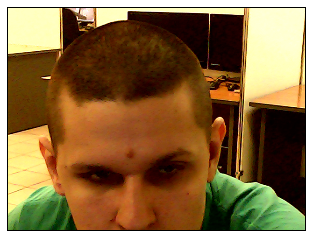

In [10]:
plt.imshow(im)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [11]:
imResize.shape
imNew = np.zeros((1, 3, width, height))
imNew = imNew.astype(np.float16)
for i in range(0, 3):
    for j in range(0, width):
        for k in range(0, height):
            imNew[0, i, j, k] = imResize[j, k, i]


(1, 3, 100, 100)


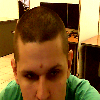

In [12]:
from scipy.misc import toimage
test = toimage(imNew[0])
print imNew.shape
test

In [18]:
int(pred[0][0] * 640 / width)

97

In [14]:
net1 = LoadNet()

  input             	(None, 3, 100, 100) 	produces   30000 outputs
  conv1             	(None, 32, 98, 98)  	produces  307328 outputs
  pool1             	(None, 32, 49, 49)  	produces   76832 outputs
  dropout1          	(None, 32, 49, 49)  	produces   76832 outputs
  conv2             	(None, 64, 48, 48)  	produces  147456 outputs
  pool2             	(None, 64, 24, 24)  	produces   36864 outputs
  dropout2          	(None, 64, 24, 24)  	produces   36864 outputs
  conv3             	(None, 128, 23, 23) 	produces   67712 outputs
  pool3             	(None, 128, 12, 12) 	produces   18432 outputs
  dropout3          	(None, 128, 12, 12) 	produces   18432 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  dropout4          	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 16)          	produces      16 outputs


(1, 16)
[[-0.69580615 -0.26126641 -0.21900961  0.94184673  0.33826029 -0.20455734
  -0.51805043 -0.21746898  0.15171337 -0.16445684 -0.1828611   0.23730232
  -0.40301219  0.51857507 -0.0142348   0.55302864]]


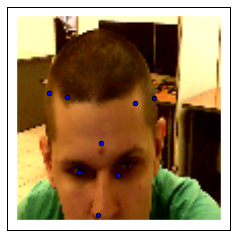

"\nfrom PIL import Image, ImageDraw, ImageFont\n\nfnt = ImageFont.truetype('/home/lao/detectKeypoint/data-latin.ttf', 10)\n\ni = 0\nsize = 1\ndraw = ImageDraw.Draw(im)\nfor i in range(0, len(pred)):\n    bbox =  (pred[i][0] - size, pred[i][1] - size, \n             pred[i][0] + size, pred[i][1] + size)\n    draw.ellipse(bbox, fill=128)\n    #draw.text((pred[i][0], pred[i][1]), str(i), font=fnt, fill=(255,255,255,128))\ndisplay(im)\n"

In [15]:
pred = net1.predict(imNew)
print pred.shape
print pred

pred = np.subtract(pred, -1)
pred = np.multiply(pred, 50)


pred = pred.reshape(len(pred[0]) / 2, 2)


plt.imshow(imResize)
for i in range(0, len(pointInSample)):
    plt.scatter(pred[i][0], pred[i][1])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

'''
from PIL import Image, ImageDraw, ImageFont

fnt = ImageFont.truetype('/home/lao/detectKeypoint/data-latin.ttf', 10)

i = 0
size = 1
draw = ImageDraw.Draw(im)
for i in range(0, len(pred)):
    bbox =  (pred[i][0] - size, pred[i][1] - size, 
             pred[i][0] + size, pred[i][1] + size)
    draw.ellipse(bbox, fill=128)
    #draw.text((pred[i][0], pred[i][1]), str(i), font=fnt, fill=(255,255,255,128))
display(im)
'''

In [16]:
pred

array([[ 15.20969296,  36.93667984],
       [ 39.04951859,  97.09233856],
       [ 66.91301727,  39.77213287],
       [ 24.09747887,  39.12655258],
       [ 57.58567047,  41.77715683],
       [ 40.85694504,  61.86511612],
       [ 29.84939194,  75.92875671],
       [ 49.28826141,  77.65142822]], dtype=float32)

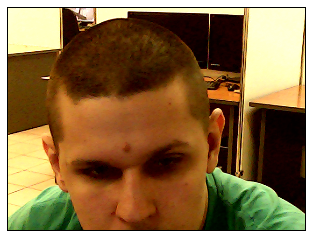

In [218]:
plt.imshow(im)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()